<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Course Rating Prediction using Neural Networks**


Estimated time needed: **60** minutes


In the previous labs, we have crafted several types of user and item feature vectors.  For example, given a user `i`, we may build its profile feature vector and course rating feature vector, and given an item `j`, we may create its genre vector and user enrollment vectors.



With these explicit features vectors, we can perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value. 

The main advantage of using these explicit features is they are highly interpretable and yield very good performance as well. The main disadvantage is we need to spend quite some effort to build and store them.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)


Is it possible to predict a rating without building explicit feature vectors beforehand?  

Yes, as you may recall, the Non-negative Matrix Factorization decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items and you can simply dot-product them to get an estimated rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features?  In fact,  neural networks are very good at learning patterns from data and are widely used to extract latent features.  When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.


## Objectives


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


## Prepare and setup lab environment


In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

2025-01-20 08:25:21.229092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 08:25:21.462451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 08:25:21.545664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 08:25:21.570820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 08:25:21.732712: I tensorflow/core/platform/cpu_feature_guar

In [2]:
random_state = 123

### Load and processing rating dataset


In [3]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())

In [5]:
print(f"num_users: {num_users}, num_items: {num_items}")

num_users: 33901, num_items: 126


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [22]:
class RecommenderNet(keras.Model):
    def __init__(self,
                 num_users: int,
                 num_items: int,
                 embedding_size: int,
                 **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name='user_bias'
        )

        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name='item_bias'
        )

    def call(self, inputs):
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        x = dot_user_item + user_bias + item_bias
        return tf.nn.relu(x)

### TASK: Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [8]:
def process_dataset(raw_data):
    encoded_data = raw_data.copy()

    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}

    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    encoded_data["rating"] = encoded_data["rating"].values.astype(int)

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [9]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [10]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [11]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [14]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [15]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [16]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [30]:
EMBEDDING_SIZE = 10
EPOCHS = 10

In [23]:
model = RecommenderNet(
    num_users=num_users,
    num_items=num_items,
    embedding_size=EMBEDDING_SIZE
)

In [26]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2
)

In [27]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [32]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stopping_callback], epochs=EPOCHS)

Epoch 1/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0060 - root_mean_squared_error: 0.0752 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1042
Epoch 2/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0050 - root_mean_squared_error: 0.0685 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1002
Epoch 3/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0607 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0965
Epoch 4/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0558 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0937
Epoch 5/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0507 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0911
Epoch 6/10
5833/5833 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0487 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0903
Epoch 7/10
5833/5833 ━━━━━━━━━━━━━

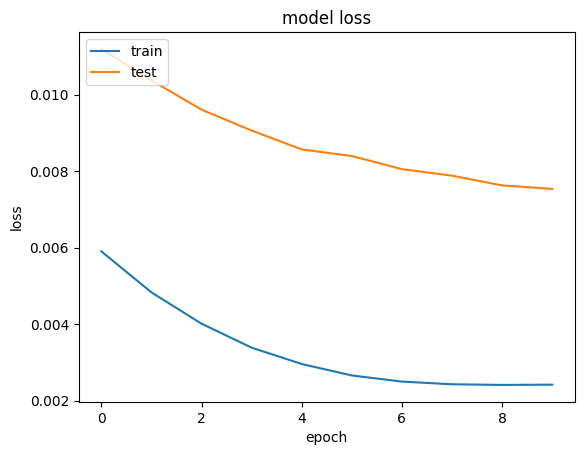

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
model.evaluate(x_test, y_test)

730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077 - root_mean_squared_error: 0.0863


[0.007537167519330978, 0.08543818444013596]

### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

If we print the trained model then we can see its layers and their parameters/weights.


In [37]:
model.summary()

Model: "recommender_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ (None, 10)             │       339,010 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ (None, 1)              │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ (None, 10)             │         1,260 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,893 (4.28 MB)

 Trainable params: 374,297 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 748,596 (2.86 MB)

In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [38]:
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"user features shape: {user_latent_features.shape}")

user features shape: (33901, 10)


In [39]:
user_latent_features[0]

array([-0.01629318, -0.04557192, -0.03457318,  0.00991574,  0.07311536,
       -0.02480683,  0.03121006, -0.04731488,  0.01090585,  0.0124368 ],
      dtype=float32)

In [40]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"item features shape: {item_latent_features.shape}")

item features shape: (126, 10)


In [41]:
item_latent_features[0]

array([ 0.00090577,  0.00187047,  0.02728169, -0.04373388,  0.02559808,
       -0.01895198,  0.01624399,  0.00812582,  0.02025381, -0.01264514],
      dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### TASK (Optional): Customize the RecommenderNet to potentially improve the model performance


The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


### Summary


In this lab, you have learned and practiced predicting course ratings using neural networks. With a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.
